<a href="https://colab.research.google.com/github/sharonibejih/leb/blob/training_notebooks/notebooks/Low_Resourced_Machine_Translation_Demo_Notebook_with_LEB_ManyToEng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation for Low-Resourced Languages

This notebook contains simple guidelines on how to train a light machine translation (MT) model using [MarianMT](https://huggingface.co/models?sort=trending&search=Helsinki-NLP) pretrained model.

## Convert Data to Leb Format.

To use the Sunbird Leb library for loading and cleaning MT datasets, your data has to look like this:

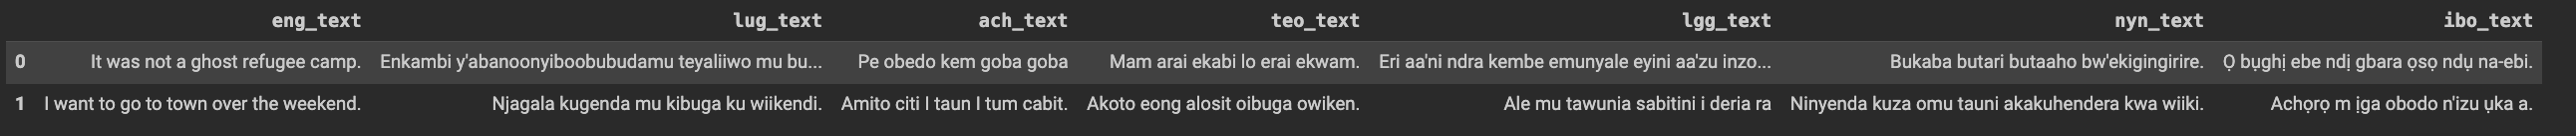



Use this [notebook](https://github.com/sharonibejih/leb/blob/training_notebooks/notebooks/Prepare_Machine_Translation_Data_In_SALT_Leb_Format.ipynb) as a guide to convert your data and push to HuggingFace Hub.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%capture
!pip install accelerate
!pip install sentencepiece
!pip install sacremoses
# Later this will just be 'pip install leb'
!git clone https://github.com/sunbirdai/leb.git
# The package requirements include transformers, datasets, etc
!pip install -r leb/requirements.txt

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import transformers
import datasets
import evaluate
import tqdm
import leb.dataset
import leb.utils
import leb.metrics
import yaml
from IPython import display

In [ ]:
datasets.__version__

'2.16.1'

In [ ]:
if torch.cuda.is_available():
  !nvidia-smi

Tue Jan 30 08:13:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%cd /content/drive/MyDrive/LebExperiments/manyToEng

/content/drive/MyDrive/LebExperiments/manyToEng


In [ ]:
# login to huggingface since some datasets loaded are stored in a private data.

!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

## Step 3: Set up configurations and load the dataset from HuggingFace using `Leb` Library

> __Note:__ The `Sunbird/external_mt_datasets` is a private repository. Only HuggingFace accounts that are added to the Sunbird organisation may access it.

In [ ]:
## THIS CELL CONTAINS ALL TRAINING SETUP

# define the artifacts directory for output files
drive_folder = "./artifacts"

if not os.path.exists(drive_folder):
  %mkdir $drive_folder

effective_train_batch_size = 3000

# Find the biggest batch size that fits in GPU memory
APPROX_MODEL_MEMORY_SIZE_MB = 310
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_memory_mb = int(gpu_info[9].split()[10][:-3])
  per_device_max_batch_size = int(gpu_memory_mb / APPROX_MODEL_MEMORY_SIZE_MB)
  B = effective_train_batch_size
  factors = np.array([x for x in range(1, B) if B % x == 0])
  train_batch_size = int(max(
      factors[factors < per_device_max_batch_size]))
  eval_batch_size = 4
else:
  train_batch_size = 1
  eval_batch_size = 1
gradient_accumulation_steps = int(effective_train_batch_size / train_batch_size)

# Everything in one yaml string, so that it can all be logged to MLFlow
yaml_config = '''
training_args:
  output_dir: "{drive_folder}"
  evaluation_strategy: steps
  eval_steps: 100
  save_steps: 100
  gradient_accumulation_steps: {gradient_accumulation_steps}
  learning_rate: 3.0e-4  # Include decimal point to parse as float
  per_device_train_batch_size: {train_batch_size}
  per_device_eval_batch_size: {eval_batch_size}
  weight_decay: 0.01
  save_total_limit: 3
  max_steps: 1000
  predict_with_generate: True
  fp16: {fp16}
  logging_dir: "{drive_folder}"
  load_best_model_at_end: True
  metric_for_best_model: loss
  label_smoothing_factor: 0.1

other_args:
  mlflow_run_name: translate-many-eng
  max_input_length: 150
  eval_pretrained_model: False
  early_stopping_patience: 5
  data_dir: .
  model_checkpoint: Helsinki-NLP/opus-mt-mul-en

common_source: &common_source
  type: text
  language: [ach,lgg,lug,nyn,teo]
  preprocessing:
    - clean_text

common_target: &common_target
  type: text
  language: [eng]
  preprocessing:
    - clean_text
    - match_target_sentence_format_to_source

load_salt: &load_salt



datasets:
  train:
    huggingface_load:
        - path: sunbird/salt
          name: text-all
          split: train
        - path: Sunbird/external_mt_datasets
          name: ai4d.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: flores200.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: lafand-en-lug-combined.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: lafand-en-luo-combined.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: mozilla_110.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: mt560_ach.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: mt560_lug.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: mt560_nyn.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_from-eng-google.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_from-lug-google.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_ach_en_14_3_23.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_en_many_30_3.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_lug_en_14_3_23.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_wiki_en_ach_30_3.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_wiki_en_lgg_30_3.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_wiki_en_lug_30_3.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_wiki_en_nyn_30_3.parquet
          split: train
        - path: Sunbird/external_mt_datasets
          name: bt_wiki_en_teo_30_3.parquet
          split: train
    source: *common_source
    target: *common_target
    shuffle: True

  validation:
    huggingface_load:
        - path: sunbird/salt
          name: text-all
          split: dev  # optionally use a slice, e.g. dev[:10] for a quick test
    source: *common_source
    target: *common_target
'''

yaml_config = yaml_config.format(
    drive_folder=drive_folder,
    train_batch_size=train_batch_size,
    eval_batch_size=eval_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    fp16=torch.cuda.is_available(),
)

config = yaml.safe_load(yaml_config)

training_settings = transformers.Seq2SeqTrainingArguments(
    **config["training_args"])

In [ ]:
train_dataset = leb.dataset.create(config['datasets']['train'])
eval_dataset = leb.dataset.create(config['datasets']['validation'])

In [ ]:
# len(list(train_dataset)) # 1421838

In [ ]:
# leb.utils.show_dataset(train_dataset, N=10)

In [ ]:
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(config['other_args']['model_checkpoint'])
tokenizer = transformers.AutoTokenizer.from_pretrained(config['other_args']['model_checkpoint'])
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model = model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/310M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/707k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/791k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

In [ ]:
train_dataset

IterableDataset({
    features: Unknown,
    n_shards: 1
})

In [ ]:
## Tokenize the text
def preprocess(examples):
    model_inputs = tokenizer(
        examples['source'], text_target=examples['target'],
        max_length=config['other_args']['max_input_length'], truncation=True)
    return model_inputs

len_languages = len(config['datasets']['validation']['source']['language'])
compute_metrics = leb.metrics.multilingual_eval_fn(
      eval_dataset, [evaluate.load('sacrebleu')],
      tokenizer, log_first_N_predictions=len_languages)

train_dataset = train_dataset.map(preprocess, batched=True)
eval_dataset = eval_dataset.map(preprocess, batched=True)

Generating train split:   0%|          | 0/23947 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/496 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

-----

## Model Building and Experiment Tracking with MlFlow and a Setup Server

There are two server set up alternatives depending on accessibility - the Sunbird server, for internal users and the Ngrok server that is publicly accessible.

### Using Sunbird Server
> If you do not have access to Sunbird server, use the Ngrok free server explained below.

1. Got to the Sunbird Gcloud console and create your credentials under `mlflow-server`.
2. Activate the generated JSON Key:




In [ ]:
# !gcloud auth activate-service-account mlflow@sb-gcp-project-01.iam.gserviceaccount.com \
#         --key-file=sb-gcp-project-01-5126f940548d.json

3. Download the JSON key and copy the path. Paste the path in the first input prompt below.

In [ ]:
# Set the Google Cloud credentials, with storage access
GOOGLE_APPLICATION_CREDENTIALS = getpass('Enter the JSON path to GCP Service Key: ')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = GOOGLE_APPLICATION_CREDENTIALS

# print(os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

# Set MLflow tracking credentials
MLFLOW_TRACKING_USERNAME = getpass('Enter the MLFLOW_TRACKING_USERNAME: ')
os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_TRACKING_USERNAME

MLFLOW_TRACKING_PASSWORD = getpass('Enter the MLFLOW_TRACKING_PASSWORD: ')
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_TRACKING_PASSWORD

# Set the MLflow tracking URI
mlflow.set_tracking_uri('http://mlflow.sunbird.ai:80')

### Using Ngrok Server

> Alternatively, use this free server if you do not have access to the Sunbird server.

__Setting up ngrok:__
- Create an account or sign up to ngrok (it's free).
- From the menu tab, select `Getting Started` > `YourAuthToken` and copy the token

__Accessing Sunbird's Server:__

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
import mlflow
import mlflow.pytorch
from pyngrok import ngrok
from getpass import getpass

# run mlflow tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Click this URL to get your authtoken https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ') # paste the token you copied
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)

print("MLflow Tracking UI:", ngrok_tunnel.public_url)

# older experiments can always be accessed via the generated ngrok public url

Enter the ngrok authtoken: ··········
MLflow Tracking UI: https://04ac-35-233-220-56.ngrok-free.app


#### Use MlFlow for Experiment Tracking

In [ ]:
!pip install git+https://github.com/huggingface/accelerate --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%pwd

'/content/drive/MyDrive/LebExperiments/manyToEng'

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision="fp16",
        log_with="tensorboard",
        project_dir="./accelerator_logs",
    )

In [ ]:
# Start run
with mlflow.start_run(run_name=f"{config['other_args']['mlflow_run_name']}-MT"):

    # Log configuration parameters
    args = (config["training_args"]|config["other_args"])
    for key, value in args.items():
        mlflow.log_param(key, value)

    trainer = transformers.Seq2SeqTrainer(
    model,
    training_settings,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [
        transformers.EarlyStoppingCallback(
            early_stopping_patience = (config['other_args']
                                            ['early_stopping_patience']))],
)


    trainer.train()

    # Access the evaluation results
    eval_results = trainer.evaluate()
    sacrebleu_score = eval_results.get("eval_sacrebleu", None)

    if sacrebleu_score is not None:
        mlflow.log_metric("sacrebleu_score", sacrebleu_score)

    # Save and log the model
    model_output_path = f"{drive_folder}/{config['other_args']['mlflow_run_name']}-model"
    model.save_pretrained(model_output_path)

    # Save and log the tokenizer
    tokenizer_output_path = f"{drive_folder}/{config['other_args']['mlflow_run_name']}-tokenizer"
    tokenizer.save_pretrained(tokenizer_output_path)
    mlflow.log_artifact(tokenizer_output_path, "tokenizer")
    mlflow.log_artifact(model_output_path, "model")


    model = accelerator.prepare(model)
    mlflow.pytorch.log_model(accelerator.unwrap_model(model), "model")

Generating train split:   0%|          | 0/15021 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/2009 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/7075 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/7262 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1427 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/73172 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/224749 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/50379 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/85513 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/29339 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/6624 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/88613 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/12304 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Bleu Ach2eng,Bleu Lgg2eng,Bleu Lug2eng,Bleu Nyn2eng,Bleu Teo2eng,Bleu Mean
100,No log,3.362535,9.633000,8.091000,26.073000,18.293000,14.073000,15.233000
200,No log,3.123237,14.366000,13.703000,28.326000,20.720000,18.315000,19.086000
300,No log,3.028867,16.199000,16.319000,28.712000,22.804000,21.927000,21.192000


First N predictions in eval set:
Prediction (ach to eng): There are a number of programs to fund farmers, True label: There are a number of wealth creation programs around agriculture
Prediction (lgg to eng): Lonyi celebrations are held in Greece., True label: There are a number of wealth creation programs around agriculture.
Prediction (lug to eng): There are a number of programs to get rid of poverty that are affecting agriculture and agriculture., True label: There are a number of wealth creation programs around agriculture.
Prediction (nyn to eng): There are many programs to promote wealth in agriculture and agriculture, True label: There are a number of wealth creation programs around agriculture
Prediction (teo to eng): There are many plans to get married in the land., True label: There are a number of wealth creation programs around agriculture.
First N predictions in eval set:
Prediction (ach to eng): There are various programs to fund agricultural activities, True label: There

Step,Training Loss,Validation Loss,Bleu Ach2eng,Bleu Lgg2eng,Bleu Lug2eng,Bleu Nyn2eng,Bleu Teo2eng,Bleu Mean
100,No log,3.362535,9.633000,8.091000,26.073000,18.293000,14.073000,15.233000
200,No log,3.123237,14.366000,13.703000,28.326000,20.720000,18.315000,19.086000
300,No log,3.028867,16.199000,16.319000,28.712000,22.804000,21.927000,21.192000
400,No log,2.972800,16.920000,17.079000,30.941000,22.719000,22.605000,22.053000
500,3.290700,2.930638,18.160000,18.346000,30.197000,23.402000,23.549000,22.731000
600,3.290700,2.903892,18.807000,18.617000,32.500000,24.638000,23.903000,23.693000


First N predictions in eval set:
Prediction (ach to eng): There is a lot of money laundering in the agricultural sector, True label: There are a number of wealth creation programs around agriculture
Prediction (lgg to eng): There is a lot of investment in agriculture., True label: There are a number of wealth creation programs around agriculture.
Prediction (lug to eng): There are many programs to get rid of poverty surrounding agriculture and agriculture., True label: There are a number of wealth creation programs around agriculture.
Prediction (nyn to eng): There are many programs to bring wealth to agriculture, True label: There are a number of wealth creation programs around agriculture
Prediction (teo to eng): There is a lot of wealth in agriculture., True label: There are a number of wealth creation programs around agriculture.
First N predictions in eval set:
Prediction (ach to eng): There are various social disbursements in agriculture, True label: There are a number of wealth 

## Inference

For inference you can reload the artifacts, either by using the local directory of fetching from mlflow.

__Using the local directory__

In [ ]:
# reload the files stored
local_model_pth = f"{drive_folder}/{config['mlflow_run_name']}-model"
local_tokenizer_pth = f"{drive_folder}/{config['mlflow_run_name']}-tokenizer"

model = transformers.AutoModelForSeq2SeqLM.from_pretrained(local_model_pth)
tokenizer = transformers.AutoTokenizer.from_pretrained(local_tokenizer_pth)

query = "Etoro m nkwado gị, ka Obianọ kwuru"
encoded = tokenizer(
        sentence_format(query), return_tensors="pt")
output = model.generate(**encoded)
tokenizer.batch_decode(
        output.cpu(), skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


["I just worked on your hand, and I said I couldn't believe myself."]

__Using mlflow filestore__

In [ ]:
import mlflow

# 1. open the generated ngrok url, and click on the experiment name
# 2. Scroll down and click on Artifacts
# 3. Click on the 'model' folder
# 4. On the left pane you will see the codes for reloading the model in pandas
# copy the code. It should look like this: Replace with yours.

run_id = '66849ff3a168499fb9366c73b0fa7ca6'

logged_model = f'runs:/{run_id}/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

## the tokeniser was logged as an artifact. So if you do not have it locally, you can download it:

tokenizer_artifact_path = f'runs:/{run_id}/tokenizer'

# Download the tokenizer files
local_tokenizer_path = mlflow.artifacts.download_artifacts(tokenizer_artifact_path)

# Just like above, load with transformers
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(local_model_pth)
tokenizer = transformers.AutoTokenizer.from_pretrained(local_tokenizer_pth)

query = "Etoro m nkwado gị, ka Obianọ kwuru"
encoded = tokenizer(
        sentence_format(query), return_tensors="pt")
output = model.generate(**encoded)
tokenizer.batch_decode(
        output.cpu(), skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


["I just worked on your hand, and I said I couldn't believe myself."]